In [1]:
from IPython.display import Image

# [[4,1,2]] surface code


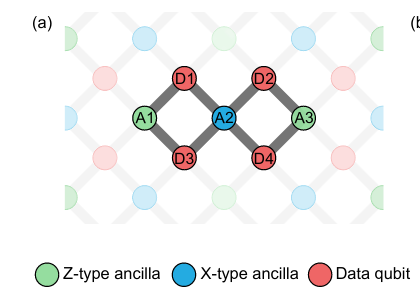

In [2]:
Image(filename="images/aa.png")

This code requires 7 qubits, out of which 4 are data qubits and 3 are ancillas. There are 8 different coupling to consider.

A full example (using Zurich) can be seen here:

https://arxiv.org/pdf/1912.09410.pdf

## quantum system

here was realized with 7 qubits with tunable flux, and CZ performed via adiabatic state transfer.

Thus we have:

7 drive IQ channels
7 flux channels
2 readout drive lines (1 to 4 and 1 to 3)
2 readout acquisition lines

In [ ]:
## maps (config)

waveforms = {  # required
    DriveChannel(1): {
        'wf_X90': {
            'i': gaussian(),
            'q': drag(),
        },
        'wf_X': {
            'i': gaussian2(),
            'q': drag2(),
        },
    },
    DriveChannel(2): {
        'wf_X90': {
            'i': gaussian(),
            'q': drag(),
        },
    },
    # etc...
}

chan_port_map = {  # not required
    # 7 qubits
    DriveChannel(1): (("con1", 1), ("con1", 2)),
    DriveChannel(2): (("con1", 3), ("con1", 4)),
    DriveChannel(3): (("con1", 5), ("con1", 6)),
    DriveChannel(4): (("con1", 7), ("con1", 8)),
    DriveChannel(5): (("con1", 9), ("con1", 10)),
    DriveChannel(6): (("con2", 1), ("con2", 2)),
    DriveChannel(7): (("con2", 3), ("con2", 4)),
    
    # 7 flux controls
    DriveChannel(9): ("con2", 5),
    DriveChannel(10): ("con2", 6),
    DriveChannel(11): ("con2", 7),
    DriveChannel(12): ("con2", 8),
    DriveChannel(13): ("con2", 9),
    DriveChannel(14): ("con2", 10),
    DriveChannel(15): ("con3", 1),
    
    # 2 readout drives
    DriveChannel(16): (("con3", 2), ("con3", 3)),
    DriveChannel(17): (("con3", 4), ("con3", 5)),

}

qubit_readout_port_map = {
    1: 16,
    2: 16,
    3: 16,
    4: 16,
    5: 17,
    6: 17,
    7: 17
}

In [ ]:
## functions definition
# note that these procedures will happen inside a qrun! 
@procedure(int, int)
def reset_qubit(qubit_channel, readout_res_channel):
    Q = declare(fixed, value=Inf)  # it would be nice to have this in principle, not mandatory
    
    play('meas_reset',
        port=chan_port_map[DriveChannel(readout_res_channel)],
        oscillator=None,  # readout channels don't need oscillators
        frame=None,  # readout channels don't need frames
        process=integration.full(Q, 'iw_reset', (("con1", 1), ("con1", 2))))
         
    with while_(Q > Q_thresh):
        play('wf_X', port=chan_port_map[DriveChannel(qubit_channel)],
             oscillator=qubit_channel,
             frame=qubit_channel)
        play('meas_reset',
             port=chan_port_map[DriveChannel(readout_res_channel)],
             oscillator=None,  # readout channels don't need oscillators
             frame=None,  # readout channels don't need frames
             process=integration.full(Q, 'iw_reset', (("con1", 1), ("con1", 2)))
            )



@procedure(int)
def hadamard(channel):
    frame_rotation_2pi(phase=0.5, frame=Frame(channel))        
    play('wf_X90',  # the specific function here is determined by the port, which should be a mandatory argument.
         oscillator=Oscillator(channel),
         frame=Frame(channel),
         port=chan_port_map[DriveChannel(channel)])                                                    
    frame_rotation_2pi(phase=0.5, frame=chan_frame_map[DriveChannel(1)])
            
        
@procedure(int)
def cphase_pulse(coupling):  # perhaps we can add a mapping type which allows us to specify for example which drive (actually control)
                             # channel corresponds to which qubit pair
    with switch_(coupling):  # here I am doing a switch case because I am not sure what is the rule in this example
        with case_(0):
            with parallel_():  # is it OK to put parallel inside procedure?
                with thread_():
                    play('cphase_bias',
                         oscillator=None,
                         frame=None,
                         port=chan_port_map[DriveChannel(9)])
                with thread_():
                    play('cphase_bias_secondary',
                         oscillator=None,
                         frame=None,
                         port=chan_port_map[DriveChannel(11)])
        with case_(1):
            pass # etc
                

@procedure(int, return_type=bool)
def measure(qubit_channel):
    Q = declare(fixed)
    se = declare(bool)
    play('measure',
        port=qubit_readout_map[qubit_channel],
        oscillator=None,
        frame=None,
        process=integration.full(Q, IntegrationWeights(qubit_channel), (("con1", 1), ("con1", 2)))
        )
    se = Q > Q_thresh
    return se
    
    
@procedure(array(bool, length=4), array(bool, length=3), return_type=bool)
def decode(data_state, ancilla_state):
    # todo
    return logical_state

In [6]:
ancilla_state = declare(bool, length=3)
data_state = declare(bool, length=4)
logical_state = declare(bool)
with qrun_():
    # state initialization
    ######################
    
    with parallel_():
        with for_((qubit_chan, rr_chan), [list(range(1,8)), [16] * 4 + [17] * 3]):  # perhaps we should think about a mapping here
            with thread_():
                reset_qubit(qubit_chan, rr_chan)

    # code cycle
    #############
    
    # X ancilla
    with parallel_():
        with for_(qubit_chan, [1, 2, 3, 4, 6]):
            with thread_():
                hadamard(qubit_chan)
                
    with for_(coupling_chan, [1, 3, 4, 6]):  # these are fairly random now,
                                             # I don't think they should be. We should have intrinsic support for multi-qubit gates.
        cphase_pulse(coupling_chan)
    with parallel_():
        with for_(qubit_chan, [1, 2, 3, 4, 6]):
            with thread_():
                hadamard(qubit_chan)
    ancilla_state[1] = measure(6)
    
    # Z ancillas
    with parallel_():
        with for_(qubit_chan, [5, 7]):
            with thread_():
                hadamard(qubit_chan)
    with for_(coupling_chan, [2, 5, 7, 8]):
        cphase_pulse(coupling_chan)
    with for_(qubit_chan, [5, 7]):
        with thread_():
            hadamard(qubit_chan)
    
    ancilla_state[0] = measure(5)
    ancilla_state[2] = measure(7)
    
    # measure all data qubits
    #########################
    
    data_state[0] = measure(1)    
    data_state[1] = measure(2)
    data_state[2] = measure(3)
    data_state[3] = measure(4)
    
logical_state = decode(data_state, ancilla_state)
  

NameError: name 'declare' is not defined